# Boya Robotu için Minimum Atıkla Yüzey Boyama - Pekiştirmeli Öğrenme Projesi

### 1. Gerekli Kütüphanelerin Yüklenmesi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import imageio.v2 as imageio
import os
import pickle

### 2. Ortam ve Q-Learning Parametrelerinin Tanımlanması

In [2]:
# ORTAM PARAMETRELERİ
GRID_SIZE = 5
MAX_PAINT = 9        # Başlangıçtaki sınırlı boya miktarı
TARGET_SIZE = 3
NUM_ACTIONS = 5      # 0:Yukarı, 1:Aşağı, 2:Sol, 3:Sağ, 4:Boyama

# ÖDÜLLER
REWARD_GOAL = 100
REWARD_MOVE_COST = -2
REWARD_WALL_HIT = -3
REWARD_SUCCESS_PAINT = 5
REWARD_ILLEGAL_PAINT = -10
REWARD_REPAINT_WASTE = -3
REWARD_NO_PAINT = -5
REWARD_MAX_STEPS_PENALTY = -20

# Q-LEARNING PARAMETRELERİ
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.95
EPISODES = 50000
MAX_STEPS = 75 

# Keşfetme Stratejisi
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.9998

ACTION_LABELS = {0:"Yukarı", 1:"Aşağı", 2:"Sol", 3:"Sağ", 4:"Boyama"}

### 3. Yardımcı Fonksiyonlar

In [3]:
def get_state_index(grid, row, col, paint_count, target_r, target_c):
    """Izgara + Boya Sayısı + Agent Konumu + Hedef Konum bilgisini tek bir indekse dönüştürür."""
    grid_int = int("".join(map(str, grid.flatten())), 2) 
    
    # Sabit Çarpanlar
    AGENT_POS_COUNT = GRID_SIZE * GRID_SIZE           # 25
    PAINT_COUNT_FACTOR = MAX_PAINT + 1                # 10
    MAX_TARGET_START = GRID_SIZE - TARGET_SIZE        # 2
    TARGET_POS_COUNT = (MAX_TARGET_START + 1) ** 2    # 9
    
    # Agent Konum İndeksi: 0 - 24
    agent_pos_index = row * GRID_SIZE + col
    
    # Target Konum İndeksi: (0,0) -> 0, (2,2) -> 8 (3x3 = 9 olası konum)
    target_index = target_r * (MAX_TARGET_START + 1) + target_c
    
    # En düşük basamak: Agent Pozisyonu (0-24)    
    index = agent_pos_index
    
    # İkinci basamak: Boya Sayısı (0-9)
    index += paint_count * AGENT_POS_COUNT
    
    # Üçüncü basamak: Hedef Konumu (0-8)
    index += target_index * PAINT_COUNT_FACTOR * AGENT_POS_COUNT
           
    # En yüksek basamak: Grid Durumu (0 - 2^25 - 1)
    index += grid_int * TARGET_POS_COUNT * PAINT_COUNT_FACTOR * AGENT_POS_COUNT
    
    return index

In [4]:
# Görselleştirme Fonksiyonları 
def plot_grid(grid, step, row, col, action_label, paint_count, reward, target_r, target_c):
    """Yeni target_r ve target_c parametrelerini ekledik."""
    fig, ax = plt.subplots(figsize=(5, 5))
    cmap = ListedColormap(['#cccccc', '#007ACC']) 
    ax.matshow(grid, cmap=cmap)
    ax.set_xticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
    ax.set_yticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', size=0)
    
    # Hedef bölge artık rastgele konumdaki (target_c, target_r) koordinatından başlar.
    ax.add_patch(plt.Rectangle((target_c - 0.5, target_r - 0.5), TARGET_SIZE, TARGET_SIZE, fill=False, edgecolor='red', linewidth=3))
    ax.plot(col, row, marker='o', color='yellow', markersize=20, alpha=0.7)
    ax.set_title(f"Adım: {step} | Konum: ({row},{col}) | Boya: {paint_count}\\nEylem: {action_label} | Ödül: {reward}", fontsize=10)
    ax.axis('off')
    
    filename = f"frame_{step:03d}.png"
    plt.savefig(filename)
    plt.close(fig) 
    return filename

def create_gif(filenames, gif_name='agent.gif'):
    """PNG dosyalarından GIF oluşturur ve dosyaları temizler."""
    print(f"\nGIF oluşturuluyor: {gif_name}...")
    
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
        
    imageio.mimsave(gif_name, images, duration=0.5, loop=0)
    
    # Geçici dosyaları temizle
    for filename in set(filenames):
        os.remove(filename)
    print("Geçici dosyalar temizlendi.")

In [5]:
def plot_performance(total_rewards, window=100, save_path='training_performance.png'):
    """
    Epizot başına alınan ödüllerin hareketli ortalamasını gösteren bir grafik oluşturur.
    """
    if not total_rewards:
        print("Hata: Ödül verisi bulunamadı.")
        return

    rewards_series = np.array(total_rewards)
    weights = np.repeat(1.0, window) / window
    
    smoothed_rewards = np.convolve(rewards_series, weights, 'valid')
    
    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_rewards, label=f'{window} Episode Hareketli Ortalaması', color='blue')
    
    # Ham ödülleri hafifçe şeffaf olarak arkaya ekleyebiliriz (isteğe bağlı)
    # plt.plot(rewards_series, alpha=0.3, color='gray', label='Ham Ödüller')

    plt.title('Ajan Eğitim Performansı Episode Başına Ortalama Ödül)')
    plt.xlabel('Episode Sayısı')
    plt.ylabel(f'Ortalama Ödül (Son {window} Episode)')
    plt.axhline(REWARD_GOAL, color='r', linestyle='--', label='Maksimum Başarı Ödülü') # Hedef ödülü çizgisi
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"Eğitim performans grafiği kaydedildi: {save_path}")

### 4. Ortamın ve Ajanın Tanımlanması

In [6]:
class GridEnvironment:
    
    def __init__(self, size=GRID_SIZE, max_paint=MAX_PAINT, target_size=TARGET_SIZE):
        self.size = size
        self.max_paint = max_paint
        self.target_size = target_size
        
        # Rastgele hedef başlangıç koordinatlarını tutacak değişkenler
        self.target_start_row = 0
        self.target_start_col = 0
        
        self.grid = None
        self.row = None
        self.col = None
        self.paint_count = None
        self.is_done = False

    def is_target(self, r, c):
        """Koordinatın hedef bölgede olup olmadığını kontrol eder."""
        return (self.target_start_row <= r < self.target_start_row + self.target_size) and \
               (self.target_start_col <= c < self.target_start_col + self.target_size)

    def is_goal_achieved(self):
        """Hedef 3x3'ün tamamen boyandığını kontrol eder."""
        target_area = self.grid[self.target_start_row:self.target_start_row + self.target_size, 
                                self.target_start_col:self.target_start_col + self.target_size]
        return np.sum(target_area) == self.target_size * self.target_size

    def reset(self, random_start=True, start_pos=None):
        self.grid = np.zeros((self.size, self.size), dtype=int)
        
        # RASTGELE HEDEF KONUMUNU BELİRLE (3x3 hedef için 5x5 ızgarada max 2x2 başlangıç)
        max_start_coord = self.size - self.target_size  # Bu değer 2'dir. (0, 1, 2)
        self.target_start_row = np.random.randint(max_start_coord + 1)
        self.target_start_col = np.random.randint(max_start_coord + 1)
        
        # AJANIN BAŞLANGIÇ KONUMU
        if random_start:
            self.row = np.random.randint(self.size)
            self.col = np.random.randint(self.size)
        else:
            self.row, self.col = start_pos
        
        self.paint_count = self.max_paint
        self.is_done = False
        
        # Durum indeksini döndür
        return get_state_index(self.grid, self.row, self.col, self.paint_count, self.target_start_row, self.target_start_col)

    def step(self, action):
        """Verilen eylemi gerçekleştirir, ödülü ve yeni durumu döndürür."""
        
        row, col = self.row, self.col
        paint_count = self.paint_count
        reward = 0
        
        new_row, new_col = row, col
        new_paint_count = paint_count
        
        # 1. Hareket Eylemleri (0, 1, 2, 3)
        if action < 4: 
            if action == 0: new_row = max(0, row - 1)
            elif action == 1: new_row = min(self.size - 1, row + 1)
            elif action == 2: new_col = max(0, col - 1)
            elif action == 3: new_col = min(self.size - 1, col + 1)
                
            if new_row == row and new_col == col:
                reward = REWARD_WALL_HIT
            else:
                reward = REWARD_MOVE_COST
                
        # 2. Boyama Eylemi (4)
        else: 
            if paint_count == 0:
                reward = REWARD_NO_PAINT
            else:
                is_painted = self.grid[row, col] == 1
                
                if not self.is_target(row, col):
                    reward = REWARD_ILLEGAL_PAINT
                    self.grid[row, col] = 1
                    new_paint_count -= 1
                
                elif is_painted:
                    reward = REWARD_REPAINT_WASTE
                    new_paint_count -= 1
                    
                else:
                    reward = REWARD_SUCCESS_PAINT
                    self.grid[row, col] = 1
                    new_paint_count -= 1

        # Durum güncellemeleri
        self.row, self.col = new_row, new_col
        self.paint_count = new_paint_count
        
        # Bitiş Koşulu Kontrolü
        if self.is_goal_achieved():
            self.is_done = True
            reward = REWARD_GOAL
        
        next_state = get_state_index(self.grid, self.row, self.col, self.paint_count, self.target_start_row, self.target_start_col)
        
        return next_state, reward, self.is_done, (self.grid, self.row, self.col, self.paint_count)

In [7]:
class QLearningAgent:
    
    def __init__(self, actions=NUM_ACTIONS, lr=LEARNING_RATE, df=DISCOUNT_FACTOR, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY):
        self.q_table = {}
        self.actions = actions
        self.lr = lr
        self.df = df
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

    def get_q_values(self, state):
        """Q-Tablosundan mevcut durumu alır veya oluşturur."""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.actions)
        return self.q_table[state]

    def choose_action(self, state, exploit_only=False):
        """Epsilon-greedy stratejisine göre eylem seçer."""
        if not exploit_only and np.random.random() < self.epsilon:
            # Keşfetme
            return np.random.randint(self.actions)
        else:
            # Sömürme
            return np.argmax(self.get_q_values(state))

    def learn(self, current_state, action, reward, next_state):
        """Q-Tablosunu günceller."""
        current_q_values = self.get_q_values(current_state)
        old_q_value = current_q_values[action]
        max_next_q = np.max(self.get_q_values(next_state))
        
        # Q-Learning Formülü
        new_q_value = old_q_value + self.lr * (reward + self.df * max_next_q - old_q_value)
        current_q_values[action] = new_q_value

    def decay_epsilon(self):
        """Epsilon değerini düşürür."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    # MODEL KAYDETME
    def save(self, filename="q_table2.pkl"):
        with open(filename, "wb") as f:
            pickle.dump(self.q_table, f)
        print(f"Model kaydedildi → {filename}")

    # MODEL YÜKLEME
    def load(self, filename="q_table2.pkl"):
        with open(filename, "rb") as f:
            self.q_table = pickle.load(f)
        print(f"Model yüklendi → {filename}")

### 5. Eğitim Fonksiyonunun Tanımlanması

In [8]:
# --- ANA EĞİTİM DÖNGÜSÜ ---
def train_agent():
    env = GridEnvironment()
    agent = QLearningAgent(NUM_ACTIONS, LEARNING_RATE, DISCOUNT_FACTOR, EPSILON_START, EPSILON_END, EPSILON_DECAY)
    
    total_rewards = []
    success_count = 0

    print("--- Q-Learning Eğitimi Başlıyor ---")

    for episode in range(EPISODES):
        current_state = env.reset() 
        episode_reward = 0
        
        for step in range(MAX_STEPS):
            
            action = agent.choose_action(current_state)
            next_state, reward, done, state_info = env.step(action)
            
            agent.learn(current_state, action, reward, next_state)
            
            episode_reward += reward
            current_state = next_state
            
            # Maksimum adıma ulaşıldıysa cezalandır
            if step == MAX_STEPS - 1 and not done:
                episode_reward += REWARD_MAX_STEPS_PENALTY
                done = True
            
            if done:
                break
                
        agent.decay_epsilon()
        
        total_rewards.append(episode_reward)
        if episode_reward == REWARD_GOAL: 
            success_count += 1

        if (episode + 1) % 1000 == 0:
            avg_reward = np.mean(total_rewards[-1000:])
            print(f"Episode: {episode + 1}/{EPISODES} | Epsilon: {agent.epsilon:.4f} | Ortalama Ödül (Son 1000): {avg_reward:.2f}")

    print("\n--- Eğitim Tamamlandı ---")
    print(f"Toplam Keşfedilen Durum Sayısı: {len(agent.q_table)}")
    #print(f"Başarı Oranı (Mükemmel Boyama): {success_count / EPISODES * 100:.2f}%")
    
    plot_performance(total_rewards, window=200)
    
    return env, agent

### 6. Test Fonksiyonunun Tanımlanması

In [9]:
def test_agent(env, agent, start_pos=None, max_steps=MAX_STEPS, fixed_target_pos=None):
    """Tek bir test episode'u çalıştırır ve üretilen frame (kare) listesini döndürür."""

    if start_pos is None:
        state = env.reset(random_start=True)
    else:
        state = env.reset(random_start=False, start_pos=start_pos)
    
    if fixed_target_pos:
        env.target_start_row, env.target_start_col = fixed_target_pos
            
    frames = []
    grid, r, c, paint = env.grid, env.row, env.col, env.paint_count
    
    # Başlangıç karesi eklenir
    frames.append(plot_grid(grid, 0, r, c, "Başlangıç", paint, 0, env.target_start_row, env.target_start_col)) 

    total_reward = 0

    for step in range(1, max_steps+1):
        if state not in agent.q_table:
            # Eğitimsiz durumla karşılaşıldı
            break

        action = agent.choose_action(state, exploit_only=True)
        next_state, reward, done, info = env.step(action)
        grid, r, c, paint = info
        total_reward += reward

        # Kare eklenir
        frames.append(plot_grid(grid, step, r, c, ACTION_LABELS[action], paint, total_reward, env.target_start_row, env.target_start_col))
        state = next_state
        
        if done:
            break
            
    create_gif(frames, gif_name="test_agent6.gif")
    return total_reward

### 7. Çalıştırma

--- Q-Learning Eğitimi Başlıyor ---
Episode: 1000/50000 | Epsilon: 0.8187 | Ortalama Ödül (Son 1000): -227.71
Episode: 2000/50000 | Epsilon: 0.6703 | Ortalama Ödül (Son 1000): -216.90
Episode: 3000/50000 | Epsilon: 0.5488 | Ortalama Ödül (Son 1000): -209.26
Episode: 4000/50000 | Epsilon: 0.4493 | Ortalama Ödül (Son 1000): -201.67
Episode: 5000/50000 | Epsilon: 0.3678 | Ortalama Ödül (Son 1000): -194.15
Episode: 6000/50000 | Epsilon: 0.3012 | Ortalama Ödül (Son 1000): -187.15
Episode: 7000/50000 | Epsilon: 0.2466 | Ortalama Ödül (Son 1000): -178.91
Episode: 8000/50000 | Epsilon: 0.2019 | Ortalama Ödül (Son 1000): -174.03
Episode: 9000/50000 | Epsilon: 0.1653 | Ortalama Ödül (Son 1000): -164.09
Episode: 10000/50000 | Epsilon: 0.1353 | Ortalama Ödül (Son 1000): -147.25
Episode: 11000/50000 | Epsilon: 0.1108 | Ortalama Ödül (Son 1000): -132.15
Episode: 12000/50000 | Epsilon: 0.0907 | Ortalama Ödül (Son 1000): -90.80
Episode: 13000/50000 | Epsilon: 0.0743 | Ortalama Ödül (Son 1000): -57.31


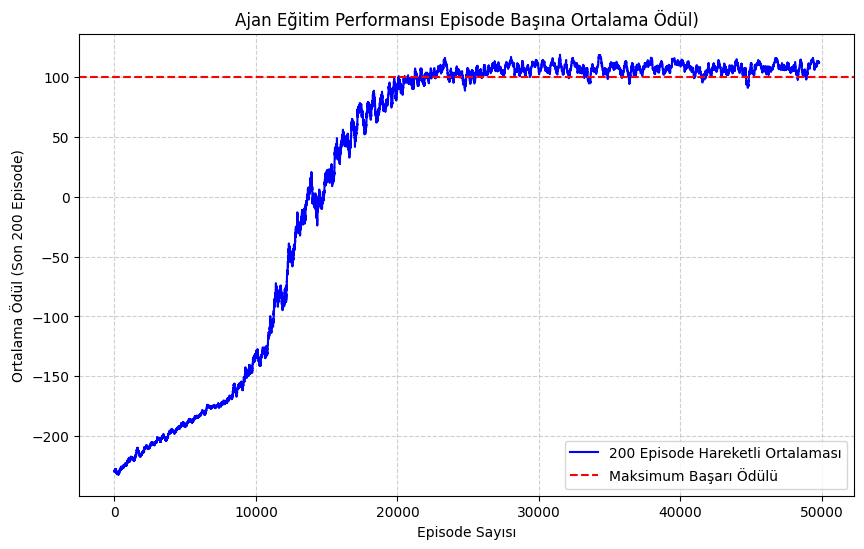

Eğitim performans grafiği kaydedildi: training_performance.png
Model kaydedildi → q_table2.pkl


In [10]:
env, agent = train_agent()
agent.save("q_table2.pkl")   # Modeli kaydet

In [11]:
agent = QLearningAgent()
agent.load("q_table2.pkl")
env = GridEnvironment()

Model yüklendi → q_table2.pkl


In [12]:
test_agent(env, agent, start_pos=(1,1), fixed_target_pos=(1,1))


GIF oluşturuluyor: test_agent6.gif...
Geçici dosyalar temizlendi.


120